# 예제: 손글씨 숫자 이미지 분류 문제

## 모듈 불러오기

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

## 분석 환경설정

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cpu


## HyperParameter 지정

In [4]:
batch_size = 50
epoch_num = 15
learning_rate = 0.0001

## 데이터 불러오기
### [MNIST 데이터 불러오기]

In [6]:
train_data = datasets.MNIST(root = '', train=True, download=True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = '', train=True, transform = transforms.ToTensor())

print('Number of training data:', len(train_data))
print('Number of test data:', len(test_data))

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 6856625.55it/s]


Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 1848468.62it/s]


Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2157989.19it/s]


Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4541246.43it/s]

Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw

Number of training data: 60000
Number of test data: 60000


## [MNIST 데이터 확인하기]

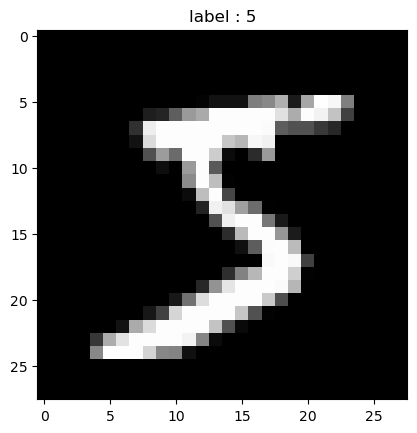

In [7]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

## [미니배치 구성하기]

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()

## [모델학습 _ CNN 구조 설계하기]

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## [Optimizer 및 손실 함수 정의] 

In [12]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 모델학습

In [13]:
model.train()
i = 0

for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0 :
            print(i , loss.item())
3        i += 1

C:\Users\aosdb\anaconda3\lib\site-packages\torch\nn\functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0 2.304090976715088
1000 0.36669281125068665
2000 0.35387906432151794
3000 0.20992118120193481
4000 0.15477700531482697
5000 0.14492449164390564
6000 0.0162254236638546
7000 0.1421404629945755
8000 0.019128311425447464
9000 0.07359495013952255
10000 0.07969367504119873
11000 0.00878160260617733
12000 0.17044544219970703
13000 0.09070635586977005
14000 0.026934748515486717
15000 0.06879696995019913
16000 0.03949470818042755
17000 0.01482237596064806


## 모델 평가

In [14]:
model.eval()
correct = 0
for data, target in test_loader:
    data.data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
    
print(100*correct / len(test_loader.dataset))

tensor(99.5983)
